In [1]:

import sys
import shap 
import pickle
import sklearn 
import numpy as np
import pandas as pd
import seaborn  as sns
from pathlib import Path
import matplotlib.pyplot as plt
from types import SimpleNamespace



In [2]:



sys.path.append("../")

from dd_package.data.dyslexia_data import DyslexiaData
from dd_package.data.preprocess import preprocess_data

from dd_package.models.regression_estimators import RegressionEstimators

from dd_package.common.utils import save_a_dict, load_a_dict, print_the_evaluated_results

from dd_package.data.preprocess import minmax_standardizer_



In [3]:

configs = {
    "models_path": Path("/home/soroosh/Programmes/DD/Models"),
    "results_path": Path("/home/soroosh/Programmes/DD/Results"),
    "figures_path": Path("/home/soroosh/Programmes/DD/Figures"),
    "params_path": Path("/home/soroosh/Programmes/DD//Params"),
    "n_repeats": 10,
    "n_splits": 5,
}

configs = SimpleNamespace(**configs)



In [4]:

data_name="dd_fix_demo"

estimator_name = "mlp_cls"
to_shuffle = True
to_exclude_at_risk = 0




In [5]:

specifier = data_name + "-" + estimator_name + \
"--shuffled:" + str(to_shuffle) + \
"--exclude at risk:" + str(to_exclude_at_risk)



In [6]:
configs.specifier = specifier
configs.data_name = data_name



In [7]:

configs.specifier



'dd_fix_demo-mlp_cls--shuffled:True--exclude at risk:0'

## Load Data

In [8]:


dd = DyslexiaData(path="../../datasets/", n_repeats=5)



In [9]:


if data_name == "dd_demo":
    # dict of dicts, s.t each dict contains pd.df of a class, e.g normal
    _ = dd.get_demo_datasets()  # demos and phonological (which is initially part of demo)
    demo_phono = dd.concat_classes_demo()

    # The optimize way to exclude at-risk class
    if to_exclude_at_risk == 1:
        to_exclude_at_risk = True
        demo_phono = demo_phono.loc[demo_phono.Group != 2]

    df_data_to_use = demo_phono.loc[:, [
                                           'Group', 'SubjectID', 'Sex', 'Grade', 'Age', 'IQ', 'Reading_speed',
                                       ]]
    c_features = ['Sex', 'Grade', ]
    indicators = ['SubjectID', ]
    targets = ["Group", "Reading_speed", ]

elif data_name == "dd_fix_demo":
    # dict of dicts, s.t each dict contains pd.df of a class, e.g normal
    _ = dd.get_demo_datasets()  # demos
    _ = dd.get_fix_datasets()  # fixes

    # concatenate pd.dfs to a pd.df
    fix = dd.concat_classes_fix()
    demo_phono = dd.concat_classes_demo()

    # The optimize way to exclude at-risk class
    if to_exclude_at_risk == 1:
        to_exclude_at_risk = True
        fix = fix.loc[fix.Group != 2]
        demo_phono = demo_phono.loc[demo_phono.Group != 2]

    fix_demo = dd.concat_dfs(
        df1=fix,
        df2=demo_phono,
        features1=fix.columns,
        features2=[
            "Sex", "Grade", "Age", "IQ", "Reading_speed",
        ],
    )

    df_data_to_use = fix_demo
    c_features = ['Sex', 'Grade', ]
    indicators = [
        'SubjectID', 'Sentence_ID', 'Word_Number',
    ]

    targets = ["Group", "Reading_speed", ]
    
elif data_name == "dd_fix":

    # dict of dicts, s.t each dict contains pd.df of a class, e.g normal
    _ = dd.get_fix_datasets()  # fixes
    # concatenate pd.dfs to a pd.df
    fix = dd.concat_classes_fix()

    # The optimize way to exclude at-risk class
    if to_exclude_at_risk == 1:
        to_exclude_at_risk = True
        fix = fix.loc[fix.Group != 2]

    df_data_to_use = fix
    c_features = None
    indicators = [
        'SubjectID', 'Sentence_ID', 'Word_Number',
    ]

    targets = ["Group", ]
    
    
    
    


x_org, y_org = dd.get_onehot_features_targets(
    data=df_data_to_use,
    c_features=c_features,
    indicators=indicators,
    targets=targets,
)



x = preprocess_data(x=x_org, pp="mm")  # only x is standardized




features = dd.features
features





Loading Demo data: 
  dyslexia (72, 9)
  norm (213, 9)
  risk (22, 9)
 
Loading Fixation report data:
  dyslexia (59770, 7)
  norm (139507, 7)
  risk (26073, 7)
 
pre-processing: mm
Preprocessed data shape: (225350, 13)


['Age',
 'IQ',
 'Sex_1',
 'Grade_2',
 'Sex_2',
 'Grade_4',
 'Grade_3',
 'FIX_Y',
 'FIX_DURATION',
 'Grade_5',
 'Grade_1',
 'Grade_6',
 'FIX_X']

In [43]:


class_names = ['Norm', 'At-risk', 'Dyslexic']



# Data investigation (old data)

In [46]:

gx_o_n = fix_demo.loc[(fix_demo.Group==1)]
gx_o_r = fix_demo.loc[(fix_demo.Group==2)]
gx_o_d = fix_demo.loc[(fix_demo.Group==3)]



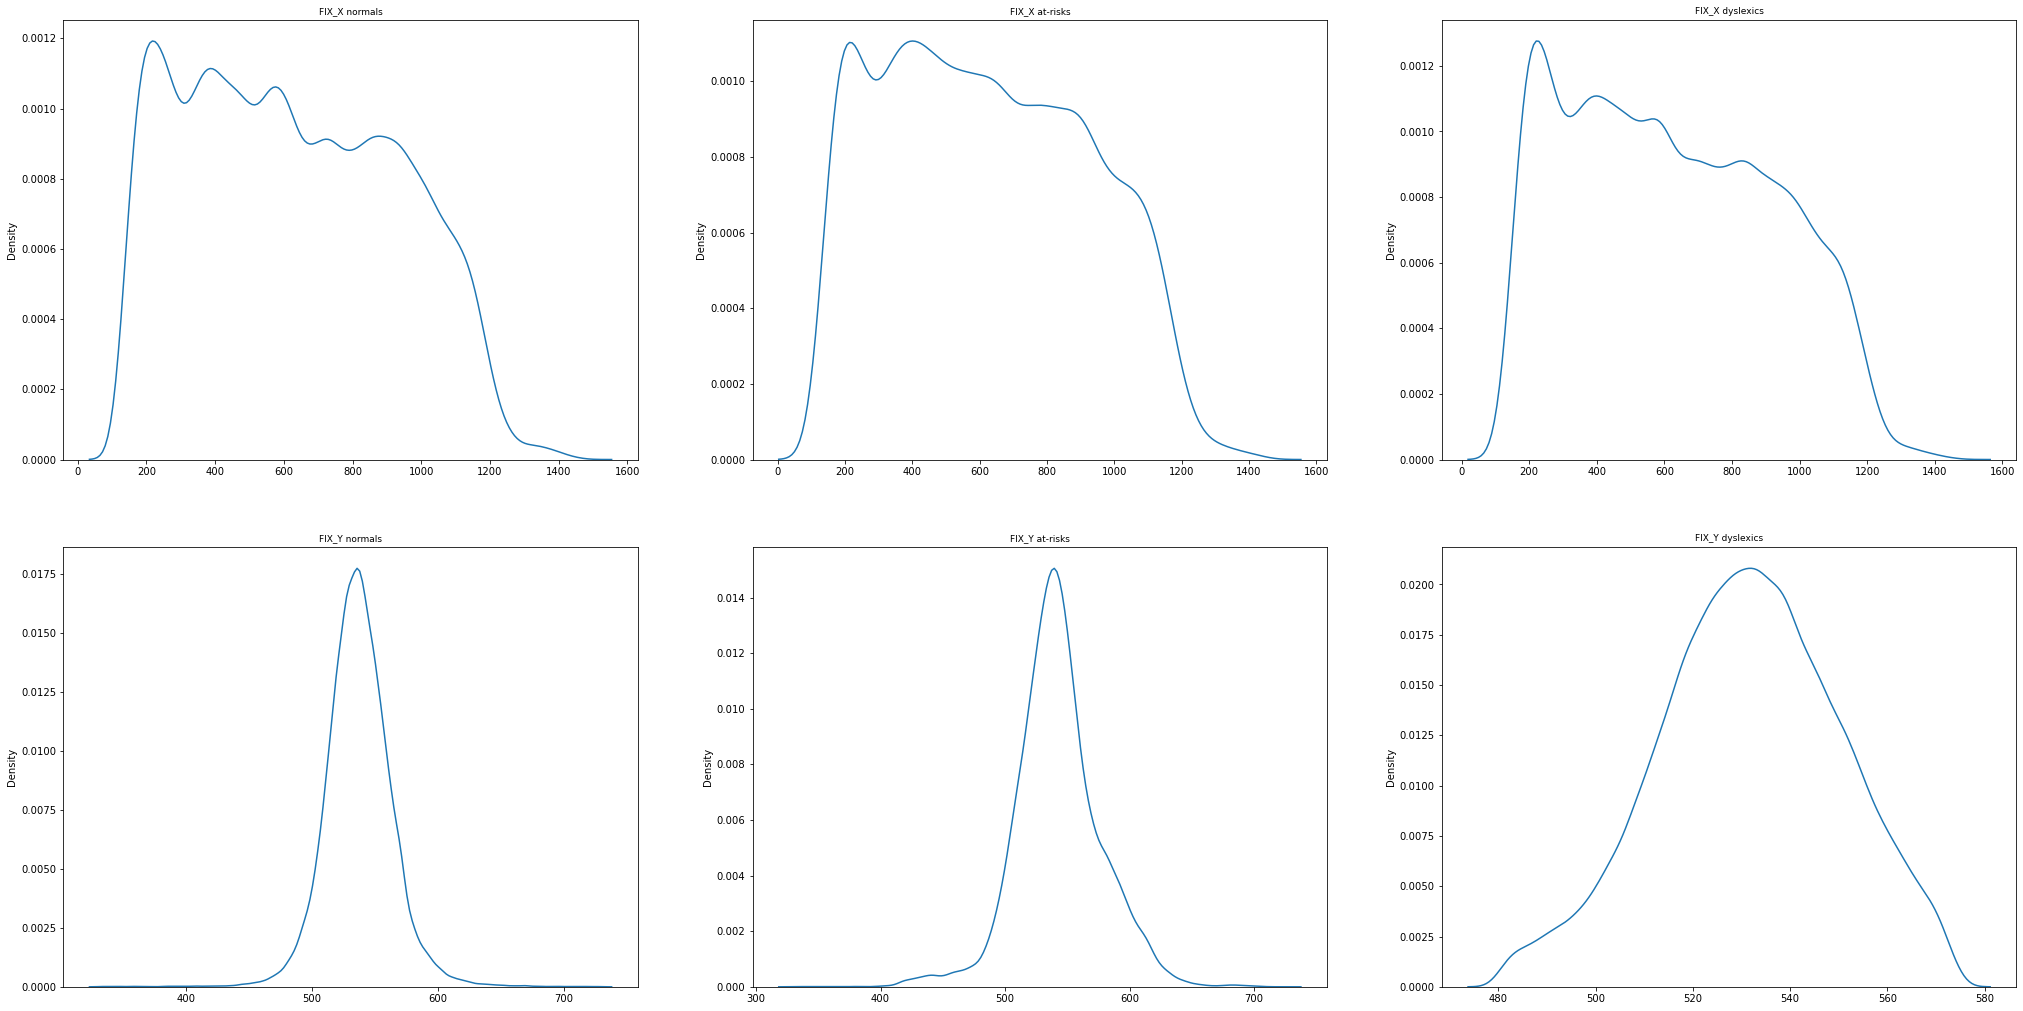

In [49]:


fig = plt.figure(figsize=(35, 25))
fig.subplots_adjust(bottom=0.05)


# FIX_X
ax = fig.add_subplot(3, 3, 1)  
sns.kdeplot(gx_o_n.FIX_X.values)
ax.set_title('FIX_X normals', fontsize=9)


ax = fig.add_subplot(3, 3, 2)  
sns.kdeplot(gx_o_r.FIX_X.values)
ax.set_title('FIX_X at-risks', fontsize=9)

ax = fig.add_subplot(3, 3, 3)  
sns.kdeplot(gx_o_d.FIX_X.values)
ax.set_title('FIX_X dyslexics', fontsize=9)


# FIX_Y
ax = fig.add_subplot(3, 3, 4)  
sns.kdeplot(gx_o_n.FIX_Y.values)
ax.set_title('FIX_Y normals', fontsize=9)


ax = fig.add_subplot(3, 3, 5)  
sns.kdeplot(gx_o_r.FIX_Y.values)
ax.set_title('FIX_Y at-risks', fontsize=9)

ax = fig.add_subplot(3, 3, 6)  
sns.kdeplot(gx_o_d.FIX_Y.values)
ax.set_title('FIX_Y dyslexics', fontsize=9)

# FIX_DUR
ax = fig.add_subplot(3, 3, 4)  
sns.kdeplot(gx_o_n.FIX_Y.values)
ax.set_title('FIX_Y normals', fontsize=9)


ax = fig.add_subplot(3, 3, 5)  
sns.kdeplot(gx_o_r.FIX_Y.values)
ax.set_title('FIX_Y at-risks', fontsize=9)

ax = fig.add_subplot(3, 3, 6)  
sns.kdeplot(gx_o_d.FIX_Y.values)
ax.set_title('FIX_Y dyslexics', fontsize=9)



plt.show()


In [15]:


g1_o_n = fix_demo.loc[(fix_demo.Grade==1) & (fix_demo.Group==1)]
g1_o_r = fix_demo.loc[(fix_demo.Grade==1) & (fix_demo.Group==2)]
g1_o_d = fix_demo.loc[(fix_demo.Grade==1) & (fix_demo.Group==3)]

g2_o_n = fix_demo.loc[(fix_demo.Grade==2) & (fix_demo.Group==1)]
g2_o_r = fix_demo.loc[(fix_demo.Grade==2) & (fix_demo.Group==2)]
g2_o_d = fix_demo.loc[(fix_demo.Grade==2) & (fix_demo.Group==3)]


g3_o_n = fix_demo.loc[(fix_demo.Grade==3) & (fix_demo.Group==1)]
g3_o_r = fix_demo.loc[(fix_demo.Grade==3) & (fix_demo.Group==2)]
g3_o_d = fix_demo.loc[(fix_demo.Grade==3) & (fix_demo.Group==3)]


g4_o_n = fix_demo.loc[(fix_demo.Grade==4) & (fix_demo.Group==1)]
g4_o_r = fix_demo.loc[(fix_demo.Grade==4) & (fix_demo.Group==2)]
g4_o_d = fix_demo.loc[(fix_demo.Grade==4) & (fix_demo.Group==3)]

g5_o_n = fix_demo.loc[(fix_demo.Grade==5) & (fix_demo.Group==1)]
g5_o_r = fix_demo.loc[(fix_demo.Grade==5) & (fix_demo.Group==2)]
g5_o_d = fix_demo.loc[(fix_demo.Grade==5) & (fix_demo.Group==3)]


g6_o_n = fix_demo.loc[(fix_demo.Grade==6) & (fix_demo.Group==1)]
g6_o_r = fix_demo.loc[(fix_demo.Grade==6) & (fix_demo.Group==2)]
g6_o_d = fix_demo.loc[(fix_demo.Grade==6) & (fix_demo.Group==3)]






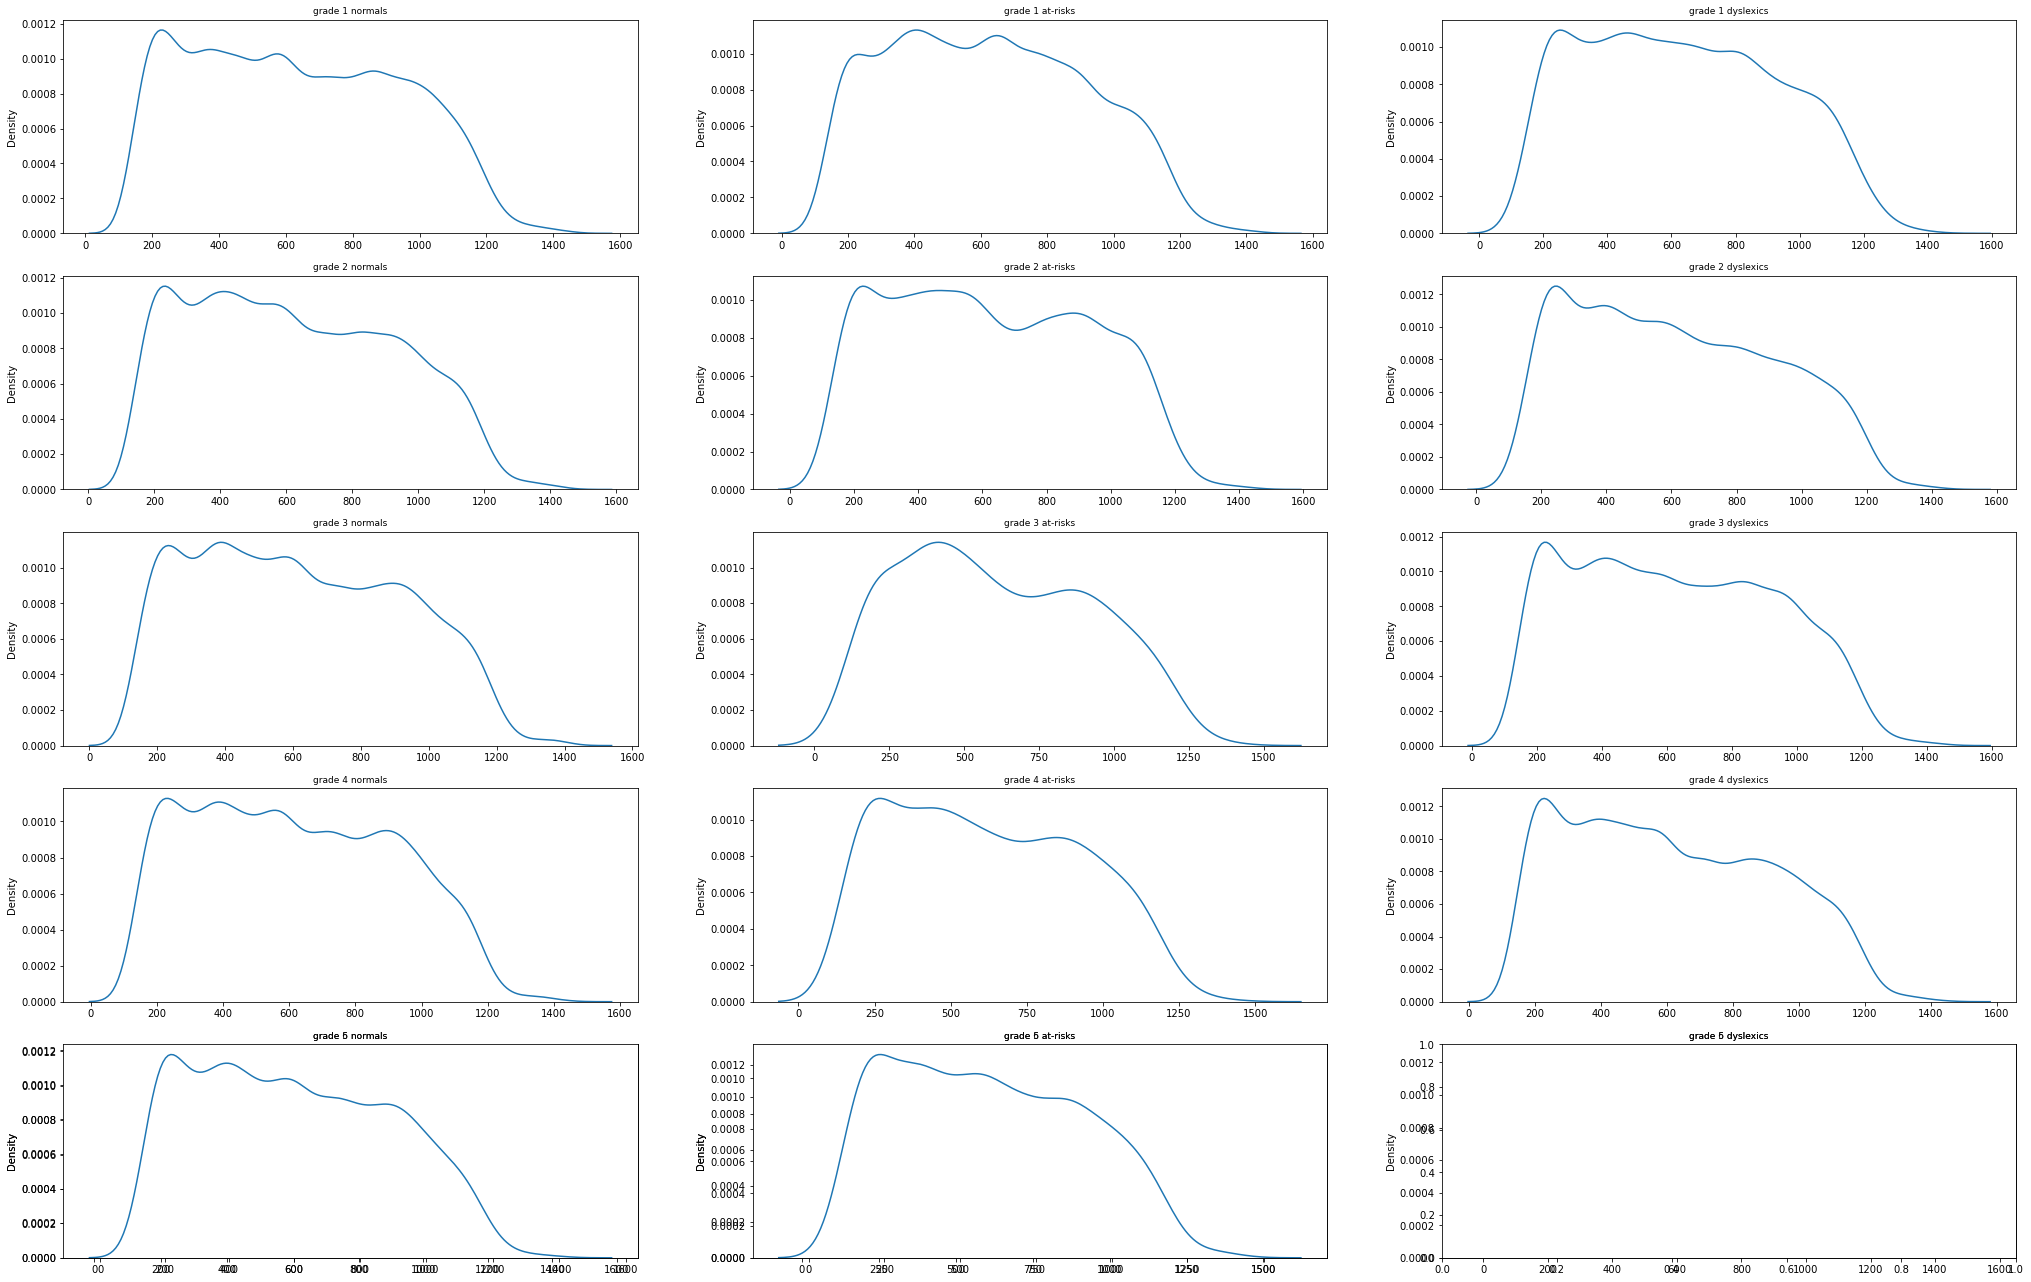

In [42]:

fig = plt.figure(figsize=(35, 25))
fig.subplots_adjust(bottom=0.05)


# grade 1
ax = fig.add_subplot(6, 3, 1)  
sns.kdeplot(g1_o_n.FIX_X.values)
ax.set_title('grade 1 normals', fontsize=9)


ax = fig.add_subplot(6, 3, 2)  
sns.kdeplot(g1_o_r.FIX_X.values)
ax.set_title('grade 1 at-risks', fontsize=9)

ax = fig.add_subplot(6, 3, 3)  
sns.kdeplot(g1_o_d.FIX_X.values)
ax.set_title('grade 1 dyslexics', fontsize=9)

# grade 2
ax = fig.add_subplot(6, 3, 4)  
sns.kdeplot(g2_o_n.FIX_X.values)
ax.set_title('grade 2 normals', fontsize=9)


ax = fig.add_subplot(6, 3, 5)  
sns.kdeplot(g2_o_r.FIX_X.values)
ax.set_title('grade 2 at-risks', fontsize=9)

ax = fig.add_subplot(6, 3, 6)  
sns.kdeplot(g2_o_d.FIX_X.values)
ax.set_title('grade 2 dyslexics', fontsize=9)


# grade 3
ax = fig.add_subplot(6, 3, 7)  
sns.kdeplot(g3_o_n.FIX_X.values)
ax.set_title('grade 3 normals', fontsize=9)


ax = fig.add_subplot(6, 3, 8)  
sns.kdeplot(g3_o_r.FIX_X.values)
ax.set_title('grade 3 at-risks', fontsize=9)

ax = fig.add_subplot(6, 3, 9)  
sns.kdeplot(g3_o_d.FIX_X.values)
ax.set_title('grade 3 dyslexics', fontsize=9)

# grade 4
ax = fig.add_subplot(6, 3, 10)  
sns.kdeplot(g4_o_n.FIX_X.values)
ax.set_title('grade 4 normals', fontsize=9)


ax = fig.add_subplot(6, 3, 11)  
sns.kdeplot(g4_o_r.FIX_X.values)
ax.set_title('grade 4 at-risks', fontsize=9)

ax = fig.add_subplot(6, 3, 12)  
sns.kdeplot(g4_o_d.FIX_X.values)
ax.set_title('grade 4 dyslexics', fontsize=9)


# grade 5
ax = fig.add_subplot(6, 3, 13)  
sns.kdeplot(g5_o_n.FIX_X.values)
ax.set_title('grade 5 normals', fontsize=9)


ax = fig.add_subplot(6, 3, 14)  
sns.kdeplot(g5_o_r.FIX_X.values)
ax.set_title('grade 5 at-risks', fontsize=9)

ax = fig.add_subplot(6, 3, 15)  
sns.kdeplot(g5_o_d.FIX_X.values)
ax.set_title('grade 5 dyslexics', fontsize=9)



# grade 6
ax = fig.add_subplot(6, 3, 13)  
sns.kdeplot(g6_o_n.FIX_X.values)
ax.set_title('grade 6 normals', fontsize=9)


ax = fig.add_subplot(6, 3, 14)  
sns.kdeplot(g6_o_r.FIX_X.values)
ax.set_title('grade 6 at-risks', fontsize=9)

ax = fig.add_subplot(6, 3, 15)  
sns.kdeplot(g6_o_d.FIX_X.values)
ax.set_title('grade 6 dyslexics', fontsize=9)

plt.show()





# Results scrutinizing

In [ ]:




results_gb_fix = load_a_dict(
    name='dd_fix-gb_cls--shuffled:True--exclude at risk:0',
    save_path=configs.results_path,
)




In [ ]:



results_gb_ia = load_a_dict(
    name='dd_ia-gb_cls--shuffled:True--exclude at risk:0',
    save_path=configs.results_path,
)





In [ ]:

y_test_gb_ia = results_gb_fix['1']['y_test']
y_pred_gb_ia = results_gb_fix['1']['y_pred']
x_test_gb_ia = results_gb_fix['1']['x_test']




In [ ]:


x_test_gd_ia_wrg = x_test_gb_ia[np.where(y_test_gb_ia != y_pred_gb_ia)]
x_test_gd_ia_crt = x_test_gb_ia[np.where(y_test_gb_ia == y_pred_gb_ia)]

x_test_gd_ia_wrg.shape, x_test_gd_ia_crt.shape


In [ ]:


idx = np.where(y_test_gb_ia == y_pred_gb_ia)[0]
idx



In [ ]:


sns.kdeplot(x_test_gd_ia_crt[:, 0], color='g', )
sns.kdeplot(x_test_gd_ia_wrg[:, 0], color='r', )
plt.legend(["correct", "wrong"])




In [ ]:



sns.kdeplot(x_test_gd_ia_crt[:, 1], color='g', )
sns.kdeplot(x_test_gd_ia_wrg[:, 1], color='r', )
plt.legend(["correct", "wrong"])



In [ ]:


sns.kdeplot(x_test_gd_ia_crt[:, 2], color='g', )
sns.kdeplot(x_test_gd_ia_wrg[:, 2], color='r', )
plt.legend(["correct", "wrong"])

